# Vision Transformer Test

```
conda create -n venv_name
conda activate venv_name
conda install pip
```

In [1]:
# Install dependencies, Conda required
!pip install ipykernel
!pip install ipywidgets
!pip install widgetsnbextension
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib
!pip install vit-pytorch
!pip install linformer

!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


Number of hot dog images:  499
Number of not hot dog images:  499


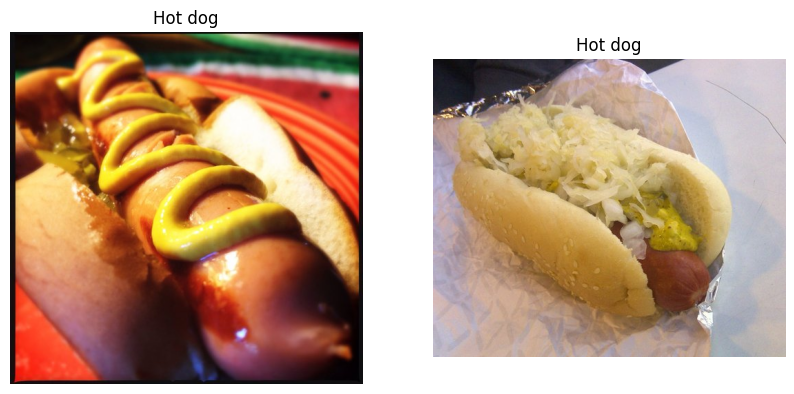

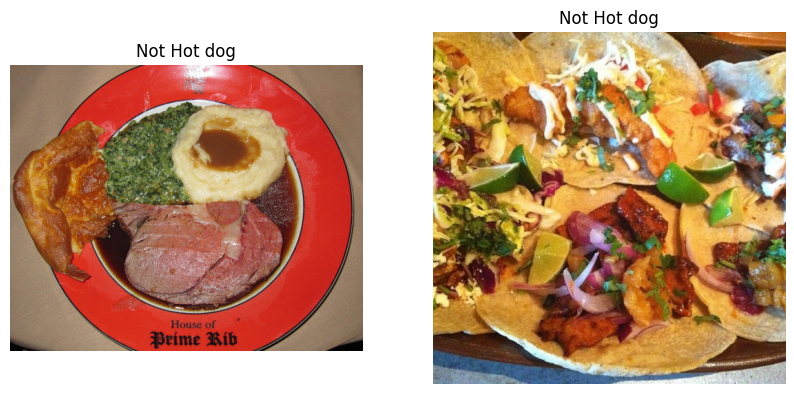

In [2]:
# First, Explore data 
import os
import glob
# dirs
train_dir = "seefood/train"
hotdog_train_dir = os.path.join(train_dir, "hot_dog")
not_hotdog_train_dir = os.path.join(train_dir, "not_hot_dog")

test_dir = "seefood/test"
hotdog_test_dir = os.path.join(test_dir, "hot_dog")
not_hotdog_test_dir = os.path.join(test_dir, "not_hot_dog")

hot_dog_train_list = glob.glob(os.path.join(hotdog_train_dir, "*.jpg"))
not_hot_dog_train_list = glob.glob(os.path.join(not_hotdog_train_dir, "*.jpg"))

hot_dog_test_list = glob.glob(os.path.join(hotdog_test_dir, "*.jpg"))
not_hot_dog_test_list = glob.glob(os.path.join(not_hotdog_test_dir, "*.jpg"))

# Let throw everything into a list, then make our own test, train splits later

all_hotdogs = hot_dog_test_list + hot_dog_train_list
all_not_hotdogs = not_hot_dog_test_list + not_hot_dog_train_list


print("Number of hot dog images: ", len(all_hotdogs))
print("Number of not hot dog images: ", len(all_not_hotdogs))

# show two random images of each train class 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
# hot dog
plt.figure(figsize=(10, 10))
for i in range(2):
    index = np.random.randint(0, len(all_hotdogs))
    plt.subplot(1, 2, i+1)
    plt.imshow(mpimg.imread(all_hotdogs[index]))
    plt.title("Hot dog")
    plt.axis("off")

# not hot dog
plt.figure(figsize=(10, 10))
for i in range(2):
    index = np.random.randint(0, len(all_not_hotdogs))
    plt.subplot(1, 2, i+1)
    plt.imshow(mpimg.imread(all_not_hotdogs[index]))
    plt.title("Not Hot dog")
    plt.axis("off")

In [15]:
# make our own train, test splits
import sklearn.model_selection as sk

all_data = all_hotdogs + all_not_hotdogs
print("Number of images in all data: ", len(all_data))

hot_dog_train_split, hot_dog_test_split = sk.train_test_split(all_hotdogs, test_size=0.1, random_state=42)
hot_dog_train_split, hot_dog_valid_split = sk.train_test_split(hot_dog_train_split, test_size=0.1, random_state=42)

nhot_dog_train_split, nhot_dog_test_split = sk.train_test_split(all_not_hotdogs, test_size=0.1, random_state=42)
nhot_dog_train_split, nhot_dog_valid_split = sk.train_test_split(nhot_dog_train_split, test_size=0.1, random_state=42)

train_split = hot_dog_train_split + nhot_dog_train_split
valid_split = hot_dog_valid_split + nhot_dog_valid_split
test_split = hot_dog_test_split + nhot_dog_test_split

print("Number of images in train split: ", len(train_split))
print("Number of images in valid split: ", len(valid_split))
print("Number of images in test split: ", len(test_split))


Number of images in all data:  998
Number of images in train split:  808
Number of images in valid split:  90
Number of images in test split:  100


In [16]:
# Perform augmentation on the data
import torchvision.transforms as transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [17]:
# print first 5 classes based on directory names of train_split
classes = [x.split("/")[-2] for x in train_split]
print("First 5 classes: ", classes[:5])

First 5 classes:  ['hot_dog', 'hot_dog', 'hot_dog', 'hot_dog', 'hot_dog']


In [18]:
from torch.utils.data import Dataset
from PIL import Image
class HotdogDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-2]

        label = 1 if label == "hot_dog" else 0
        return img_transformed, label

In [19]:
train_data = HotdogDataset(train_split, transform=train_transforms)
valid_data = HotdogDataset(valid_split, transform=val_transforms)
test_data = HotdogDataset(test_split, transform=test_transforms)

from torch.utils.data import DataLoader
train_loader = DataLoader(dataset = train_data, batch_size=64, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=64, shuffle=True)

# print labels of first 5 train_data 
print("First 5 labels: ", [train_data[i][1] for i in range(5)])

First 5 labels:  [1, 1, 1, 1, 1]


In [20]:
# Prep Cuda

def seed_everything(seed):
    import torch
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [21]:
#Training

from linformer import Linformer
from vit_pytorch.efficient import ViT

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to("cuda")

In [22]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch
from tqdm.notebook import tqdm

# Training settings
batch_size = 64
epochs = 30
lr = 3e-5
gamma = 0.7
seed = 42
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [23]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to("cuda")
        label = label.to("cuda")

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to("cuda")
            label = label.to("cuda")

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7031 - acc: 0.4882 - val_loss : 0.6939 - val_acc: 0.4886



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6973 - acc: 0.5144 - val_loss : 0.6866 - val_acc: 0.5343



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7075 - acc: 0.4998 - val_loss : 0.7088 - val_acc: 0.4886



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.7003 - acc: 0.5062 - val_loss : 0.6865 - val_acc: 0.5228



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6929 - acc: 0.5178 - val_loss : 0.6855 - val_acc: 0.6280



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6891 - acc: 0.5262 - val_loss : 0.6842 - val_acc: 0.6316



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6898 - acc: 0.5262 - val_loss : 0.6864 - val_acc: 0.6088



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6854 - acc: 0.5526 - val_loss : 0.6792 - val_acc: 0.5499



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6898 - acc: 0.5356 - val_loss : 0.6826 - val_acc: 0.5781



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6847 - acc: 0.5656 - val_loss : 0.6859 - val_acc: 0.5781



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6881 - acc: 0.5625 - val_loss : 0.6823 - val_acc: 0.5583



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6836 - acc: 0.5608 - val_loss : 0.6770 - val_acc: 0.6466



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6846 - acc: 0.5514 - val_loss : 0.6771 - val_acc: 0.6118



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6840 - acc: 0.5572 - val_loss : 0.6792 - val_acc: 0.5583



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6844 - acc: 0.5632 - val_loss : 0.6843 - val_acc: 0.5583



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6824 - acc: 0.5764 - val_loss : 0.6857 - val_acc: 0.4886



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6899 - acc: 0.5433 - val_loss : 0.6877 - val_acc: 0.5427



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6741 - acc: 0.5822 - val_loss : 0.6816 - val_acc: 0.5349



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6804 - acc: 0.5697 - val_loss : 0.6830 - val_acc: 0.6352



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6793 - acc: 0.5625 - val_loss : 0.6936 - val_acc: 0.5469



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.6894 - acc: 0.5296 - val_loss : 0.6785 - val_acc: 0.6623



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.6982 - acc: 0.5358 - val_loss : 0.6722 - val_acc: 0.5499



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6826 - acc: 0.5536 - val_loss : 0.6696 - val_acc: 0.6238



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.6788 - acc: 0.5719 - val_loss : 0.6897 - val_acc: 0.5126



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.6805 - acc: 0.5688 - val_loss : 0.6736 - val_acc: 0.5817



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.6853 - acc: 0.5548 - val_loss : 0.6796 - val_acc: 0.5781



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.6808 - acc: 0.5659 - val_loss : 0.6727 - val_acc: 0.5775



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.6753 - acc: 0.5647 - val_loss : 0.6732 - val_acc: 0.6130



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.6724 - acc: 0.5834 - val_loss : 0.6729 - val_acc: 0.5775



  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.6766 - acc: 0.5810 - val_loss : 0.6804 - val_acc: 0.6130

